In [1]:
import sys
import os
import networkx as nx
from sympy import *
from bond_graph import *
# from bond_graph_nodes import *
from scipy import *
import time
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2


## Mass-Spring-Damper Simulation Example
This notebook gives an example of how a bond graph system represented  **Note this is not an end-to-end demonstration of the machine learning process, but rather a demonstration of how a candidate system design is represented and its performance assessed via some pre-defined metric.**

In [2]:
# Initialize bond graph
t_span = [0, 10]
time_array = np.linspace(t_span[0], t_span[1], 500)

G = BondGraph(max_nodes=20, max_states=4, time_array=time_array)
G.add_element(EffortSource())
G.add_element(OneJunction())
G.add_bond(1, 0, -1)
G.add_element(Capacitance(capacitance=0.05))
G.add_bond(1, 2, 1)
G.add_element(Inertance(inertance=3))
G.add_bond(3, 1, -1)
G.add_element(Resistance(resistance=20))
G.add_bond(1, 4, 1)


### Graph Representations

Visualization of the graph and its node properties.

Note that there are "reflexive causality" conditions that arise from Newton's laws. The visualized graph is the flow-causal representation, but we can equivalently represent it in an edge-causal manner. This is why the flow and causal adjacency matrices are transposes of each other.

Nodes:
{'element_type': <BondGraphElementTypes.EFFORT_SOURCE: 1>, 'max_ports': 1, 'params': {}, 'Se': Se_0, 'element_label': 'Se_0'}
{'element_type': <BondGraphElementTypes.ONE_JUNCTION: 4>, 'max_ports': None, 'params': {}, 'element_label': '1_1'}
{'element_type': <BondGraphElementTypes.CAPACITANCE: 5>, 'max_ports': 1, 'params': {'C': 0.05}, 'q': q_2, 'q_dot': q_dot_2, 'element_label': 'C_2'}
{'element_type': <BondGraphElementTypes.INERTANCE: 6>, 'max_ports': 1, 'params': {'I': 3}, 'p': p_3, 'p_dot': p_dot_3, 'element_label': 'I_3'}
{'element_type': <BondGraphElementTypes.RESISTANCE: 7>, 'max_ports': 1, 'params': {'R': 20}, 'element_label': 'R_4'}

Flow Adjacency Matrix
[[0 0 0 0 0]
 [1 0 1 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]

Effort Adjacency Matrix
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]


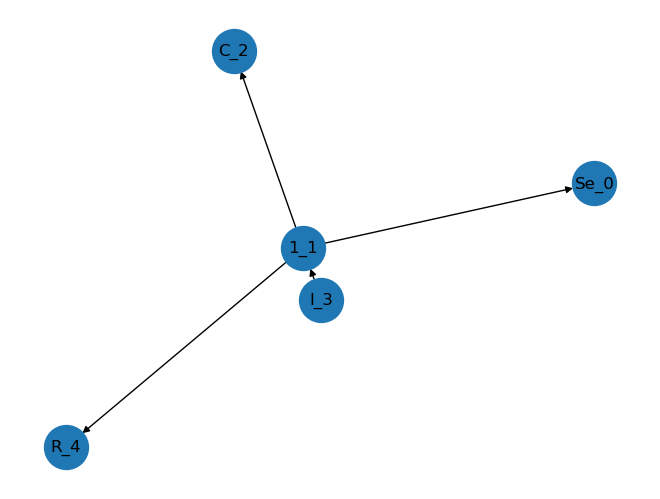

In [3]:
# Draw the bond graph with labels
labels = nx.get_node_attributes(G.flow_causal_graph, 'element_label')
nx.draw(G.flow_causal_graph, labels=labels, with_labels=True, node_size=1000)

# Print the adjacency matrix
print("Nodes:")
for node in G.flow_causal_graph.nodes:
    print(G.flow_causal_graph.nodes[node])
# print(G.flow_causal_graph.nodes(data=True))
print()

print("Flow Adjacency Matrix")
print(nx.adjacency_matrix(G.flow_causal_graph).todense())
print()
print("Effort Adjacency Matrix")
print(nx.adjacency_matrix(G.effort_causal_graph).todense())


## Compute the equations of motion based on the constitutive laws encoded by the graph
The BondGraph class keeps track of whether the system is realizable or not by checking adjacency between sets of nodes (I've chosen an example here that is realizable for sake of demonstration). When a physically realizable system is rpesent, we can compute the overall system dynamics by creating a system of equations by invoking the constitutive law at each node. These are shown below as a set of sympy (symbolic python package) equations.

The sympy equations are then converted into a matrix formulation $Ax=b$. By providing the solver with the control inputs and current state at each time-step and substituting these values into $b$, we can solve for $x$ (the state derivatives and bond variables).


In [4]:
# Compute the overall system dynamics of the bond graph
G.update_state_space_matrix(verbose=True)

Bond Graph Variables: 
State Derivatives:  [q_dot_2, p_dot_3]
States:  [q_2, p_3]
Bonds:  [e_1:0, f_1:0, e_1:2, f_1:2, e_1:4, f_1:4, e_3:1, f_3:1]

Constitutive Laws: 
[Eq(q_dot_2, f_1:2), Eq(p_dot_3, e_3:1), Eq(Se_0, e_1:0), Eq(-e_3:1, -e_1:0 + e_1:2 + e_1:4), Eq(f_3:1, f_1:0), Eq(f_3:1, f_1:2), Eq(f_3:1, f_1:4), Eq(e_1:2, 20.0*q_2), Eq(f_3:1, p_3/3), Eq(e_1:4, 20*f_1:4)]

Matrix Formulation (Ax = b): 
A (10, 10): Matrix([[1, 0, 0, 0, 0, -1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, -1, 0], [0, 0, -1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, -1, 0, -1, 0, -1, 0], [0, 0, 0, -1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, -1, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, -1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, -20, 0, 0]])
b (10, 1): Matrix([[0], [0], [-Se_0], [0], [0], [0], [0], [20.0*q_2], [p_3/3], [0]])
x (10): [q_dot_2, p_dot_3] [e_1:0, f_1:0, e_1:2, f_1:2, e_1:4, f_1:4, e_3:1, f_3:1]


## Simulate the forced forward dynamics

In [5]:
t_span = [0, 10]
t = np.linspace(t_span[0], t_span[1], 500)
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [6]:
t_span = [0, 10]
t = np.linspace(t_span[0], t_span[1], 100)

x0 = [0, 0] # Initial conditions

# Generate a forcing input at 5 hertz
omega = 2*np.pi*0.1
u = lambda t: [np.sin(omega*t)]

y = integrate.odeint(G.dynamics, x0, t, args=(u,))


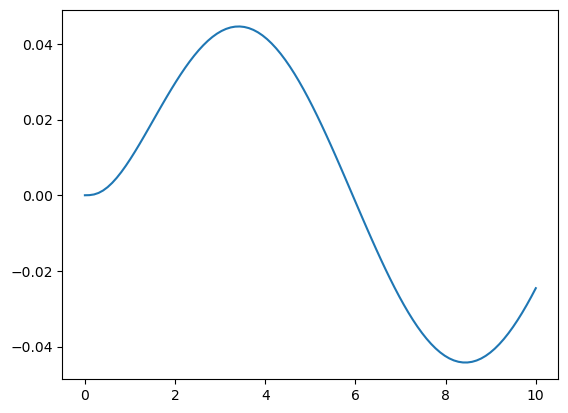

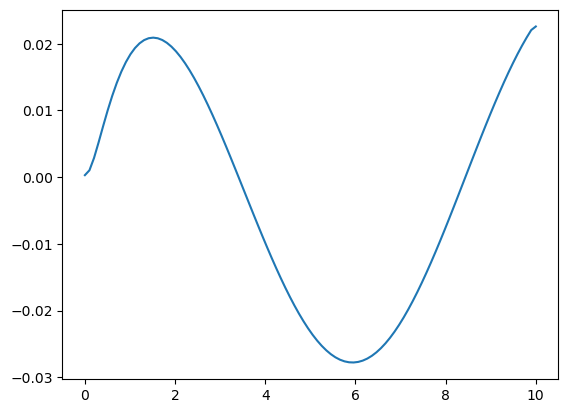

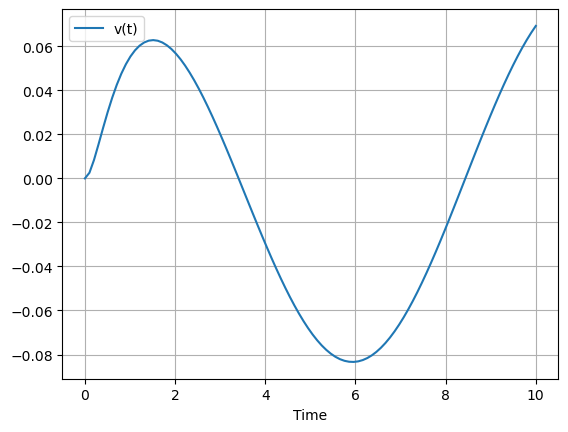

In [7]:
a = np.gradient(y[:, 1])
dt = t[1] - t[0]

(ts, num_states) = shape(y)
plt.plot(t, y[:, 0], label='x(t)')
plt.plot(t, np.gradient(y[:, 0], dt), label='v(t) grad')
plt.show()
plt.plot(t, y[:, 1], label='v(t)')
# plt.plot(t,a, label='a(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()


In [8]:
# Define the range of frequencies over which to compute the response
# frequencies = np.logspace(-3, 3, 5)  # frequencies from 0.1 to 100

# # Initialize arrays to store the magnitude and phase
# magnitude = np.zeros_like(frequencies)
# phase = np.zeros_like(frequencies)

# # Loop over frequencies
# for i, omega in enumerate(frequencies):
#     # Generate a sinusoidal input at the current frequency
#     u = lambda t: [np.sin(omega*t)]
    
#     # Simulate the system
#     y = integrate.odeint(G.dynamics, x0, t, args=(u,))
    
#     # Compute the magnitude and phase of the output
#     output = y[:, 0]  # assuming the output is the first state
#     magnitude[i] = np.max(output)  # magnitude is the maximum output
#     phase[i] = np.argmax(output) * 2 * np.pi / len(t)  # phase is the time of the maximum output, converted to radians

# # Plot the magnitude and phase
# plt.figure()
# plt.semilogx(frequencies, magnitude)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Magnitude')
# plt.grid()

# plt.figure()
# plt.semilogx(frequencies, phase)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Phase [rad]')
# plt.grid()

# plt.show()

## Compute the reward based on a vibration isolation nomograph metric
For this problem, we will use a common vibration isolation metric where the peak displacement and velocity are monitored. This can be specified as an infinity signal norm on the state variables in the graph (the higher the norm, the worse the design). For sake of demonstration, I'll weigh the displacement 10x as much as the velocity equally: $$\text{Reward} = 10||x(t)||_\infty + ||v(t)||_\infty$$


Coming up with proper weights for these values is still something I'm struggling with on the RL side.


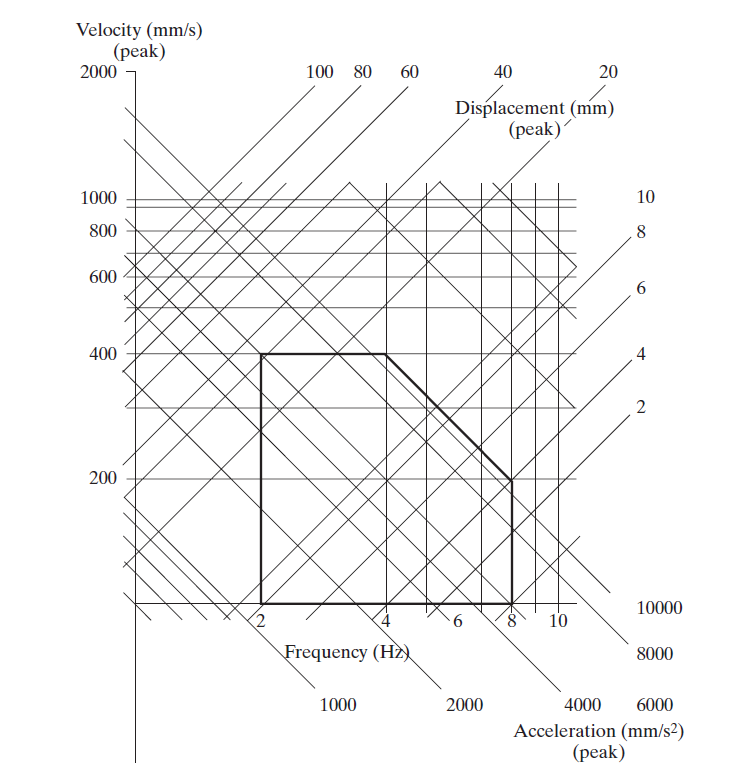


In [9]:
reward1 = 10*np.linalg.norm(y[:,0], np.inf) + np.linalg.norm(y[:,1], np.inf)
print(reward1)
print(10*np.linalg.norm(y[:,0], 2) + np.linalg.norm(y[:,1], 2)) 
print(G.reward())

0.5292309724105517
3.6466132087174357
13427.974227634244


## Generating a New Design and Comparing
To simulate an episode of the RL agent's potential actions (adding nodes/edges), I'll now modify the bond graph to add another damper into the vibration isolator. We then compute the reward again to demonstrate that we've improved the design.

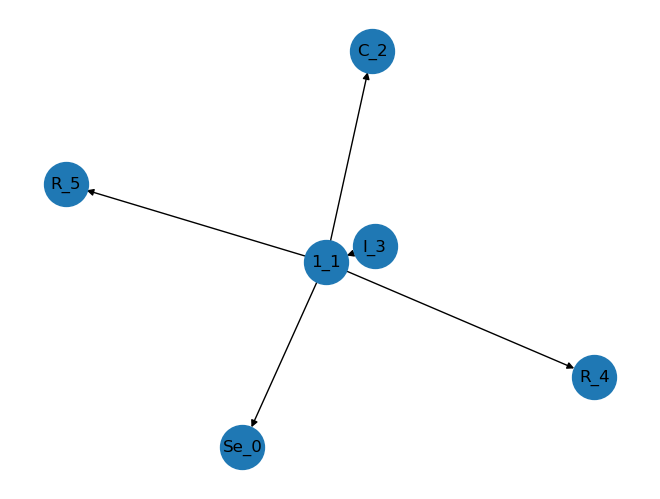

In [10]:
G = BondGraph(max_nodes=20, max_states=4, time_array=time_array)
G.add_element(EffortSource())
G.add_element(OneJunction())
G.add_bond(1, 0, -1)
G.add_element(Capacitance(capacitance=0.05))
G.add_bond(1, 2, 1)
G.add_element(Inertance(inertance=3))
G.add_bond(3, 1, -1)
G.add_element(Resistance(resistance=5))
G.add_bond(1, 4, 1)

## Only this is new and corresponds to the new actions, i repeated the above initialization so we can run this cell independently
G.add_element(Resistance(resistance=1))
G.add_bond(1, 5, 1)

# Draw the new graph
labels = nx.get_node_attributes(G.flow_causal_graph, 'element_label')
nx.draw(G.flow_causal_graph, labels=labels, with_labels=True, node_size=1000)


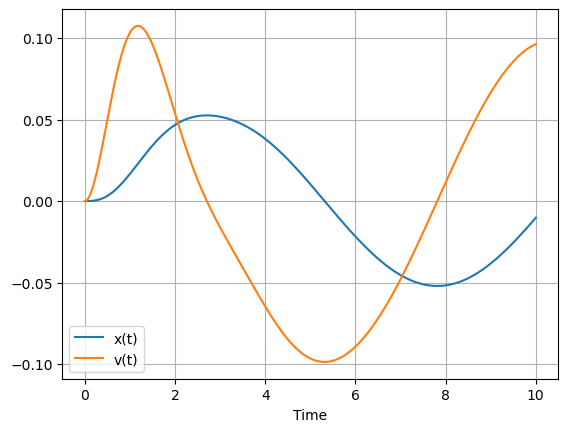

In [11]:
# Update the system dynamics
G.update_state_space_matrix(verbose=False)

# Forward simulate
t_span = [0, 10]
t = np.linspace(t_span[0], t_span[1], 500)
x0 = [0, 0] # Initial conditions

# Generate a forcing input at 5 hertz
omega = 2*np.pi*0.1
u = lambda t: [np.sin(omega*t)]

y = integrate.odeint(G.dynamics, x0, t, args=(u,))

(ts, num_states) = shape(y)
plt.plot(t, y[:, 0], label='x(t)')
plt.plot(t, y[:, 1], label='v(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [12]:
reward2 = 10*np.linalg.norm(y[:,0], np.inf) + np.linalg.norm(y[:,1], np.inf)

print(reward2)
reward2 < reward1

0.6331506162736175


False

The rewards here might seem flipped, but that's since our metric prioritizes minimizing this norm. We can just multiply by -1 in the RL agent to change it to a maximization problem. Qualitatively from the graph, we can see the vibration reduction resulting from this addition of a damper.